In [1]:
from fastai.vision.all import *
from fastai.medical.imaging import get_dicom_files, PILDicom
import warnings
warnings.filterwarnings('ignore')


# ResNets for Biomedical Image Analysis

In this lesson, we will expand upon Convolutional Neural Networks (CNNs) to understand the ResNet (Residual Network) architecture, a powerful tool in medical image analysis. ResNets were introduced in 2015 by Kaiming He et al. in ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385). Since then, ResNets have been widely adopted, particularly for medical imaging applications such as MRI, CT, and X-ray image classification. The architecture’s main advantage is its ability to train very deep networks, which is essential when detecting subtle patterns in high-resolution medical images.

We’ll first explore the ResNet basics, then discuss recent modifications that enhance its performance. 


## Function Classes

When designing neural networks, it is useful to think about the **function class** that a given architecture can represent. Formally, let $\mathcal{F}$ denote the set of all functions that can be realized by a specific network architecture together with a choice of hyperparameters (such as learning rate, initialization, or regularization). In other words, for any $f \in \mathcal{F}$ there exists a set of weights and biases such that training can produce $f$.

Now suppose there exists a “true” underlying function $f^*$ that perfectly describes the relationship between inputs and outputs in our data. If $f^* \in \mathcal{F}$, then in principle we are in good shape: with enough training data and proper optimization, our model class is expressive enough to capture the truth. However, this is rarely the case in practice. Typically, $f^*$ lies outside the scope of $\mathcal{F}$, so instead we aim for the **best possible approximation** within our class:

$$
f^*_{\mathcal{F}} \;=\; \arg\min_{f \in \mathcal{F}} L(\mathbf{X}, \mathbf{y}, f),
$$

where $L(\mathbf{X}, \mathbf{y}, f)$ is the loss on training data. Thus $f^*_{\mathcal{F}}$ represents the best function achievable with the chosen model family.

### Larger Function Classes

One might assume that enlarging the function class should always yield a better approximation. For instance, if we replace $\mathcal{F}$ with a richer class $\mathcal{F}'$, it seems natural to expect $f^*_{\mathcal{F}'}$ to be “closer” to $f^*$. However, this is **not guaranteed** unless $\mathcal{F}$ is contained within $\mathcal{F}'$.

* For **non-nested classes**, increasing capacity can sometimes move us *further away* from the truth. As illustrated in the figure below, $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, but $\mathcal{F}_6$ moves further away. Simply enlarging the space of possible solutions is not enough.
* For **nested classes** ($\mathcal{F}*1 \subseteq \mathcal{F}*2 \subseteq \dots$), each expansion strictly increases expressive power, guaranteeing that $f^**{\mathcal{F}*{k+1}}$ is at least as good as $f^*_{\mathcal{F}_k}$ (in terms of approximation error).

![functionclasses](./images/resnet/nested_func.png)

This distinction highlights why architectural design matters: not every added layer or parameter leads to meaningful improvements.

### Deep Networks and the Identity Function

For deep neural networks, these considerations are especially important. Suppose we add an extra layer to a model. If that layer cannot be trained to act like the identity function ($f(\mathbf{x}) = \mathbf{x}$), the enlarged network might actually perform worse—it could distort representations in unhelpful ways.

But if the identity function is included in the function class of the deeper model, then at worst the network can reproduce the performance of the shallower model. At best, it may use the added layer to discover a representation that reduces training error.

This insight directly motivated the development of **residual networks (ResNets)** by He et al. (2016). The key idea is that each new block of layers should easily implement the identity mapping, and then learn *residual functions* on top of it. Mathematically, instead of learning an arbitrary transformation $F(\mathbf{x})$, a residual block learns

$$
\mathbf{y} = F(\mathbf{x}) + \mathbf{x},
$$

so that if $F(\mathbf{x}) = 0$, the block simply passes its input through unchanged. This ensures that deeper networks contain their shallower counterparts as special cases.

### Impact and Broader Use

Residual connections had a transformative impact on deep learning. With them, very deep networks (hundreds of layers) became trainable and achieved state-of-the-art results. ResNets won the 2015 ImageNet Large Scale Visual Recognition Challenge and reshaped the design of deep models.

Since then, the principle of **skip connections** or **residual links** has been adopted widely:

* **Recurrent networks:** to stabilize training of long sequences (Prakash et al., 2016; Kim et al., 2017).
* **Transformers:** the architecture that dominates NLP and vision relies heavily on residual connections to stack many layers effectively (Vaswani et al., 2017).
* **Graph neural networks:** residual links improve stability and depth (Kipf & Welling, 2016).
* **Computer vision models:** from object detection (Ren et al., 2015) to real-time models (Redmon & Farhadi, 2018).


## Brain Tumor Detection

Let’s consider a dataset containing brain MRI images. Each image is labeled based on the presence or absence of pneumothorax, allowing us to classify between classes such as gliomas, meningiomas, and healthy tissue. Given the high-resolution 3D MRI data, we’ll downscale it to 128×128 images and use random cropping to 96×96 to expedite our training.


In [2]:
from datasets import load_dataset

ds = load_dataset("TrainingDataPro/brain-mri-dataset")

INFO:datasets:PyTorch version 2.4.1 available.


Resolving data files:   0%|          | 0/276 [00:00<?, ?it/s]

In [25]:
class_names = ds['train'].features['label'].names

def ensure_grayscale(x:PILBase):
    return x.convert("L")

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),  # Load images in default format
    get_x=lambda record: record['image'],
    get_y=lambda record: class_names[record['label']],
    item_tfms=[Resize(128), ensure_grayscale, RandomCrop(94)],  
)

# dblock.summary(ds['train'])
dls = dblock.dataloaders(ds['train'], bs=4)


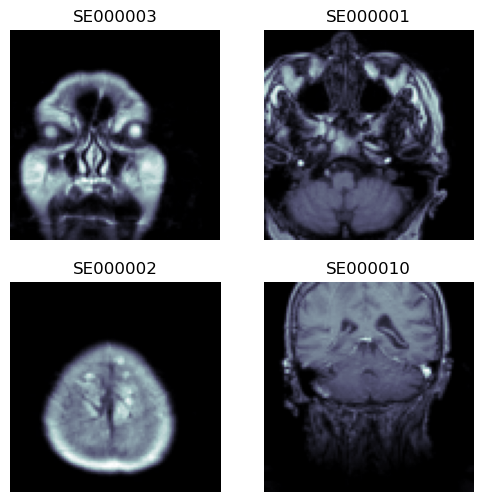

In [27]:
dls.show_batch(max_n=4, cmap='bone')

## Fully Convolutional Networks for Flexible Input Sizes

One key requirement for working with 3D medical images, such as MRIs or CT scans, is the ability to handle variable image sizes. When scanning different organs or regions of interest, the resolution may vary. In the past, CNNs would flatten the last convolutional layer and connect it to dense layers, which fixed the input size. Fully convolutional networks (FCNs), however, allow us to apply the network to images of any size by using an average pooling layer to collapse spatial dimensions.

In PyTorch, we can define a simple average pooling function like this:


In [28]:
def avg_pool(x): return x.mean((2,3))


For greater flexibility, we can use `nn.AdaptiveAvgPool2d(1)` to average over variable spatial dimensions, transforming the output grid of activations to a single activation vector per image. We then feed this into a final dense layer, which predicts the class.

### Example of a Fully Convolutional Network for Medical Imaging

Here’s a basic fully convolutional network setup suitable for MRI classification, where we use a series of convolutions followed by adaptive pooling and a final dense layer:


In [29]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(1, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))



In [30]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

In [31]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.101657,1.932110,0.345455,00:01
1,1.970474,1.597681,0.472727,00:01
2,1.818230,1.446884,0.563636,00:01
3,1.759295,1.320569,0.581818,00:01
4,1.624759,1.314690,0.600000,00:01



## Building a Modern CNN: ResNet

With standard CNNs, adding more layers can sometimes lead to worse performance on both training and validation sets, even with batch normalization. This issue was addressed in the original ResNet paper. ResNet introduces the concept of **skip connections**, which helps networks to train effectively even when they are very deep. In medical imaging, this is crucial because detecting features like subtle tumor boundaries often requires more layers to capture intricate details.

### Skip Connections

The concept of a skip connection is simple yet powerful. Instead of training each layer independently, we allow each layer to access both the features learned by the preceding layers and the original input. Mathematically, we add the input $ x $ to the output of a series of convolutional layers, such that the network learns a residual function $ F(x) $ instead of a direct mapping $ H(x) $:

$$
H(x) = F(x) + x
$$

This approach helps the model focus on the differences (residuals) that distinguish various tumor types, making the network easier to train with gradient-based optimizers.

![res_block](./images/resnet/resblock.png)

In [32]:
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni,nf),
            ConvLayer(nf,nf, norm_type=NormType.BatchZero)
        )
        
    def forward(self, x): return x + self.convs(x)


This basic ResNet block works well when the input and output dimensions match. But medical imaging tasks often require resizing or downsampling layers.

### Handling Variable Sizes and Channels with ResNet Blocks

To allow downsampling and channel adjustment, we can modify the ResNet block to handle cases where the input and output sizes differ. For instance, using average pooling with a stride of 2 can reduce spatial dimensions, while a 1×1 convolution adjusts the number of channels.


In [34]:
def _conv_block(ni, nf, stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero)
    )

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))


### Training the ResNet Model

We can now define our model and start training on the MRI data. The skip connections and ResNet blocks make it possible to use deeper networks, enhancing our model’s ability to detect small-scale patterns in MRI scans that may signify different types of tumors.


In [35]:
def block(ni, nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())
learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,accuracy,time
0,2.178780,2.313758,0.145455,00:02
1,2.031109,1.796856,0.545455,00:02
2,1.861223,1.566142,0.454545,00:02
3,1.698381,1.437361,0.563636,00:02
4,1.659433,1.449389,0.600000,00:02



## Bottleneck Layers for Efficient Training in Medical Imaging

Deeper models generally perform better for medical image tasks, as they allow for multi-level feature learning. For very deep ResNets, like ResNet-50 or ResNet-101, we can use bottleneck layers. These layers use three convolutions: a 1×1 layer to reduce channels, a 3×3 layer for feature extraction, and another 1×1 layer to restore channels. This reduces computational cost while maintaining high performance—a crucial feature for computationally intensive 3D scans.

![Comparison of regular and bottleneck ResNet blocks (courtesy of Kaiming He et al.)](images/Lesson_06_bottleneck.png)

In [36]:
def _conv_block(ni, nf, stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride),
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero)
)

## Training a State-of-the-Art ResNet

In the paper ["Bag of Tricks for Image Classification with Convolutional Neural Networks"](https://arxiv.org/abs/1812.01187), Tong He et al. explore a range of modifications to the ResNet architecture that add minimal computational overhead or extra parameters. By fine-tuning the ResNet-50 architecture and incorporating Mixup—a data augmentation technique—they achieved a top-5 accuracy of 94.6% on the ImageNet dataset, compared to the standard ResNet-50's 92.2% without Mixup. Remarkably, this improved accuracy surpasses that of much deeper ResNet models, which are not only slower but also more prone to overfitting. We’ll implement this optimized ResNet design as we expand to a full ResNet model, given its enhanced performance.

This optimized version starts with a slightly different structure: instead of beginning with ResNet blocks directly, it uses a series of initial convolutional layers followed by a max-pooling layer. These initial layers, known as the *stem* of the network, are designed as follows:

In [37]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [38]:
#hide_output
_resnet_stem(1,32,32,64)

[ConvLayer(
   (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

Starting with simple convolutional layers in a ResNet, rather than ResNet blocks, optimizes computational efficiency. In the initial layers, the network processes high-resolution input (e.g., a 128×128 image), requiring a kernel operation on each pixel. This results in significant computation compared to later layers, where the spatial dimensions are smaller (e.g., 4×4 or 2×2). 

Early layers also have fewer parameters; for instance, a 3×3 kernel with 3 input and 32 output channels has only 864 weights, while deeper layers might exceed a million. Since ResNet blocks are more computationally intense with multiple convolutions, beginning with basic convolutions keeps the initial operations fast and effective.

The following implementation of ResNet uses four groups of ResNet blocks, with 64, 128, 256, then 512 filters. Each group starts with a stride-2 block, except for the first one, since it's just after a `MaxPooling` layer:

In [39]:
class ResNet(nn.Sequential):
    def __init__(self,n_in, n_out, layers, expansion=1):
        stem = _resnet_stem(n_in,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

The `_make_layer` function assembles a specified number of `n_layers` blocks. The first block transitions from `ch_in` to `ch_out` with the specified `stride`, while the subsequent blocks use a stride of 1 and maintain `ch_out` dimensions. Defining these blocks in sequence allows our model to be purely sequential, which is why we use `nn.Sequential`.

Different ResNet versions (e.g., ResNet-18, -34, -50) adjust the number of blocks within each group. Here is the definition of a ResNet-50:

In [41]:
rn = ResNet(1, dls.c, [3,4,6,3])  # Using a deeper model
learn = get_learner(rn)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.073302,1.942665,0.345455,00:04
1,1.777766,1.389966,0.581818,00:04
2,1.510835,1.041325,0.709091,00:04
3,1.265770,0.780747,0.818182,00:04
4,1.202722,0.738354,0.781818,00:04


## Improved Loss Landscape with ResNet

One of the reasons ResNets work so well in medical imaging is that skip connections smooth the loss landscape, reducing the risk of sharp local minima that hinder optimization. Studies, such as the one by Hao Li et al. in ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/abs/1712.09913), show that ResNets exhibit smoother loss surfaces, making them particularly robust for applications like tumor classification where high accuracy and stability are crucial.

![Impact of ResNet on loss landscape (courtesy of Hao Li et al.)](images/Lesson_06_loss_landscape.png)

By building ResNet architectures with these advanced techniques, we can create robust models tailored to the complex, high-dimensional data encountered in biomedical engineering.

## ResNeXt and Grouped Convolutions

ResNeXt was introduced as a refinement of ResNet to better balance the trade-off between depth, width, and computational efficiency in convolutional blocks. In ResNets, we can increase expressiveness either by stacking more nonlinear layers or by widening convolutions to handle more channels, but widening quickly becomes expensive since the cost of transforming $c_i$ input channels into $c_o$ output channels grows as $\mathcal{O}(c_i \cdot c_o)$. 

ResNeXt lets information flow through multiple parallel paths which perform the *same* transformation. This leads to a simpler and more scalable design where convolutions are split into *groups*, hence we talk of **grouped convolutions**. A grouped convolution divides the $c_i$ input channels into $g$ groups, each mapped to $c_o/g$ outputs, reducing both parameters and computation by roughly a factor of $g$ since the cost drops from $\mathcal{O}(c_i \cdot c_o)$ to $\mathcal{O}(c_i \cdot c_o / g)$. Even better, the number of parameters needed to generate the output is also reduced from a $c_\textrm{i} \times c_\textrm{o}$ matrix to $g$ smaller matrices of size $(c_\textrm{i}/g) \times (c_\textrm{o}/g)$, again a $g$ times reduction. In what follows we assume that both $c_\textrm{i}$ and $c_\textrm{o}$ are divisible by $g$.

To avoid groups becoming completely isolated, ResNeXt uses a bottleneck design: the grouped $3\times 3$ convolution is placed between two $1\times 1$ convolutions, the first shrinking the number of channels and the second restoring them, while residual connections ensure stable training. This block, which generalizes the residual block, achieves efficiency by concentrating most computation in the lightweight grouped convolution, while still allowing global channel mixing through the $1\times 1$ layers. 

The grouped convolution idea dates back to AlexNet (2012), where it was originally used to split computation across two GPUs, but ResNeXt elevated it to a principled architectural feature. In practice, ResNeXt blocks are used much like ResNet blocks: with stride 1 and no projection the input and output shapes match, while adding a $1\times 1$ projection with stride 2 halves spatial resolution. The result is a highly modular, simple-to-scale architecture that consistently outperforms plain ResNets at comparable cost, and its concept of grouped transformations has influenced many later CNN designs.

ResNeXt is an example for how the design of convolutional neural networks has evolved over time: by being more frugal with computation and trading it off against the size of the activations (number of channels), it allows for faster and more accurate networks at lower cost. An alternative way of viewing grouped convolutions is to think of a block-diagonal matrix for the convolutional weights. Note that there are quite a few such “tricks” that lead to more efficient networks. For instance, ShiftNet (Wu et al., 2018) mimicks the effects of a $ 3 \times 3 $ convolution, simply by adding shifted activations to the channels, offering increased function complexity, this time without any computational cost.